## PART C - PREDICTION OF CANCER SURVIVAL

Dataset : Wisconsin Prognostic Breast Cancer Dataset

Glossary:
This file contains patients' nuclear features, survival time and chemotherapy 
information.  The 39 columns contain the following information:

* Patient's artificially created number i=1,......,253.
* 2.  code_a = 0 if non-recur
             = 1 if recur
* 3.  code_b = 0 if death is not caused by cancer or person leaves the group
		     = 1 if death is caused by cancer
* 4.  time_a = time (months) DFS/TTR 
		       DFS : Disease Free Survival (code a=0)
         	   TTR : Time To Recur (if code a=1)
* 5.  time_b = survival time (months) for patients who die, leave or survive the total time of the study 158 months at December 1997.
* 6.  radius
* 7.  texture
* 8.  perimeter
* 9.  area
* 10.  smoothness
* 11.  compactness
* 12.  concavity
* 13.  concave point
* 14.  symmetry
* 15.  fractal dimension
* 16. to 25. Standard devisation of 6. to 15. above
* 26. to 35. Largest (worst) of 6. to 15. above
* 36.  tumor size
* 37.  Q(i, 36) = Lymph node status 
	  (number of metastasized lymph nodes: 0 to 30)
* 38.   hormo = 1 if patient received first chemotherapy
			  = 0 otherwise
* 39.   chemo = 1 if patient received second chemotherapy
			  = 0 otherwise

The text in the document by Gauresh Chavan, Kaushal Chaudhary and Mohit Ruke is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The code in the document by Gauresh Chavan, Kaushal Chaudhary and Mohit Ruke is licensed under the MIT License https://opensource.org/licenses/MIT

              

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly
import plotly.graph_objs as go
from sklearn import metrics
from time import time
%matplotlib inline

**Installing packages**
Credits:[Randal Olson TPOT](http://www.randalolson.com/2015/11/15/introducing-tpot-the-data-science-assistant/)

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.
TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for our data.Once TPOT is finished searching, it provides us with the Python code for the best pipeline it found so you can tinker with the pipeline from there.

In [1]:
!pip install boruta
!pip install tpot

  Running setup.py bdist_wheel for boruta: started
  Running setup.py bdist_wheel for boruta: finished with status 'done'
  Stored in directory: C:\Users\rukem\AppData\Local\pip\Cache\wheels\5c\5a\72\13e8ea10ba10e22e9ca7f76f8b451c9f98fa190d428c8857dd
Successfully built boruta


You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Running setup.py bdist_wheel for tpot: started
  Running setup.py bdist_wheel for tpot: finished with status 'done'
  Stored in directory: C:\Users\rukem\AppData\Local\pip\Cache\wheels\00\f3\4d\8d28f69c59669ba720eebaa4ebc8a3b28da2a61662367b38e8
  Running setup.py bdist_wheel for deap: started
  Running setup.py bdist_wheel for deap: finished with status 'done'
  Stored in directory: C:\Users\rukem\AppData\Local\pip\Cache\wheels\22\ea\bf\dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
  Running setup.py bdist_wheel for stopit: started
  Running setup.py bdist_wheel for stopit: finished with status 'done'
  Stored in directory: C:\Users\rukem\AppData\Local\pip\Cache\wheels\3c\85\2b\2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built tpot deap stopit


You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

In [13]:
## importing the dataset
dataset = pd.read_csv("WPBCC.csv")
dataset.head()

,PATIENT,CODE_A,CODE_B,TIME_A,TIME_B,RADIUS,TEXTURE,PERIMETR,AREA,SMOOTH,...,WSMOOTH,WCOMPCT,WCONCV,WCONV_PT,WSYMM,WFRACT_D,SIZE,NODE_ALL,CHEMO,HORMO
0,1,0,0,55,55,18.02,27.60,117.50,1013.0,0.09489,...,0.1195,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5,1,1
1,2,0,0,29,29,14.09,27.70,96.01,604.7,0.11860,...,0.1555,0.5988,0.7392,0.18710,0.2497,0.11830,0.8,0,0,0
2,3,0,0,53,53,13.32,27.25,85.99,551.7,0.08446,...,0.1197,0.3018,0.3039,0.11670,0.2859,0.08557,1.3,0,0,0
3,4,1,0,12,68,15.11,32.79,99.36,712.3,0.09656,...,0.1408,0.4667,0.6024,0.12780,0.2773,0.10450,2.5,0,0,0
4,5,0,0,56,56,13.99,36.52,92.27,598.3,0.11780,...,0.1613,0.2520,0.3125,0.09596,0.2154,0.07969,0.8,1,0,1


In [14]:
data = dataset[['PATIENT','CODE_B', 'CODE_A', 'TIME_A', 'TIME_B', 'RADIUS', 'TEXTURE',
       'PERIMETR', 'AREA', 'SMOOTH', 'COMPCT', 'CONCV', 'CONV_PT', 'SYMM',
       'FRACT_D', 'SRADIUS', 'STEXTURE', 'SPERIMET', 'SAREA', 'SSMOOTH',
       'SCOMPCT', 'SCONCV', 'SCONV_PT', 'SSYMM', 'SFRACT_D', 'WRADIUS',
       'WTEXTURE', 'WPERIMET', 'WAREA', 'WSMOOTH', 'WCOMPCT', 'WCONCV',
       'WCONV_PT', 'WSYMM', 'WFRACT_D', 'SIZE', 'NODE_ALL', 'CHEMO', 'HORMO']]
data.head()

,PATIENT,CODE_B,CODE_A,TIME_A,TIME_B,RADIUS,TEXTURE,PERIMETR,AREA,SMOOTH,...,WSMOOTH,WCOMPCT,WCONCV,WCONV_PT,WSYMM,WFRACT_D,SIZE,NODE_ALL,CHEMO,HORMO
0,1,0,0,55,55,18.02,27.60,117.50,1013.0,0.09489,...,0.1195,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5,1,1
1,2,0,0,29,29,14.09,27.70,96.01,604.7,0.11860,...,0.1555,0.5988,0.7392,0.18710,0.2497,0.11830,0.8,0,0,0
2,3,0,0,53,53,13.32,27.25,85.99,551.7,0.08446,...,0.1197,0.3018,0.3039,0.11670,0.2859,0.08557,1.3,0,0,0
3,4,0,1,12,68,15.11,32.79,99.36,712.3,0.09656,...,0.1408,0.4667,0.6024,0.12780,0.2773,0.10450,2.5,0,0,0
4,5,0,0,56,56,13.99,36.52,92.27,598.3,0.11780,...,0.1613,0.2520,0.3125,0.09596,0.2154,0.07969,0.8,1,0,1


In [15]:
## X are the varibles used for predictions Y is the target
X = data.drop(['PATIENT','CODE_B'],axis=1)
Y = data['CODE_B']
X.head()

,CODE_A,TIME_A,TIME_B,RADIUS,TEXTURE,PERIMETR,AREA,SMOOTH,COMPCT,CONCV,...,WSMOOTH,WCOMPCT,WCONCV,WCONV_PT,WSYMM,WFRACT_D,SIZE,NODE_ALL,CHEMO,HORMO
0,0,55,55,18.02,27.60,117.50,1013.0,0.09489,0.10360,0.10860,...,0.1195,0.1926,0.3140,0.11700,0.2677,0.08113,5.0,5,1,1
1,0,29,29,14.09,27.70,96.01,604.7,0.11860,0.25530,0.24860,...,0.1555,0.5988,0.7392,0.18710,0.2497,0.11830,0.8,0,0,0
2,0,53,53,13.32,27.25,85.99,551.7,0.08446,0.07879,0.05168,...,0.1197,0.3018,0.3039,0.11670,0.2859,0.08557,1.3,0,0,0
3,1,12,68,15.11,32.79,99.36,712.3,0.09656,0.12230,0.13380,...,0.1408,0.4667,0.6024,0.12780,0.2773,0.10450,2.5,0,0,0
4,0,56,56,13.99,36.52,92.27,598.3,0.11780,0.14060,0.10720,...,0.1613,0.2520,0.3125,0.09596,0.2154,0.07969,0.8,1,0,1


In [16]:
data.isnull().sum()

PATIENT     0
CODE_B      0
CODE_A      0
TIME_A      0
TIME_B      0
RADIUS      0
TEXTURE     0
PERIMETR    0
AREA        0
SMOOTH      0
COMPCT      0
CONCV       0
CONV_PT     0
SYMM        0
FRACT_D     0
SRADIUS     0
STEXTURE    0
SPERIMET    0
SAREA       0
SSMOOTH     0
SCOMPCT     0
SCONCV      0
SCONV_PT    0
SSYMM       0
SFRACT_D    0
WRADIUS     0
WTEXTURE    0
WPERIMET    0
WAREA       0
WSMOOTH     0
WCOMPCT     0
WCONCV      0
WCONV_PT    0
WSYMM       0
WFRACT_D    0
SIZE        0
NODE_ALL    0
CHEMO       0
HORMO       0
dtype: int64

In [17]:
data.duplicated().sum()

0

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 39 columns):
PATIENT     253 non-null int64
CODE_B      253 non-null int64
CODE_A      253 non-null int64
TIME_A      253 non-null int64
TIME_B      253 non-null int64
RADIUS      253 non-null float64
TEXTURE     253 non-null float64
PERIMETR    253 non-null float64
AREA        253 non-null float64
SMOOTH      253 non-null float64
COMPCT      253 non-null float64
CONCV       253 non-null float64
CONV_PT     253 non-null float64
SYMM        253 non-null float64
FRACT_D     253 non-null float64
SRADIUS     253 non-null float64
STEXTURE    253 non-null float64
SPERIMET    253 non-null float64
SAREA       253 non-null float64
SSMOOTH     253 non-null float64
SCOMPCT     253 non-null float64
SCONCV      253 non-null float64
SCONV_PT    253 non-null float64
SSYMM       253 non-null float64
SFRACT_D    253 non-null float64
WRADIUS     253 non-null float64
WTEXTURE    253 non-null float64
WPERIMET    25

In [19]:
## Fitting the data in random forest algorithm by splitting it into training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random)


In [10]:
tpot = TPOTClassifier(generations=10, population_size=50, verbosity=2)
tpot.fit(X_train, Y_train)
print(tpot.score(X_test, Y_test))

D:\Anaconda\lib\importlib\_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



Generation 1 - Current best internal CV score: 0.9503658536585367


Generation 2 - Current best internal CV score: 0.9503658536585367


Generation 3 - Current best internal CV score: 0.9503658536585367


Generation 4 - Current best internal CV score: 0.9503658536585367


Generation 5 - Current best internal CV score: 0.9503658536585367


Generation 6 - Current best internal CV score: 0.9503658536585367


Generation 7 - Current best internal CV score: 0.9503658536585367


Generation 8 - Current best internal CV score: 0.9551219512195122


Generation 9 - Current best internal CV score: 0.9551219512195122


Generation 10 - Current best internal CV score: 0.9551219512195122



Best pipeline: ExtraTreesClassifier(LogisticRegression(MaxAbsScaler(input_matrix), C=1.0, dual=False, penalty=l2), bootstrap=True, criterion=gini, max_features=0.75, min_samples_leaf=1, min_samples_split=13, n_estimators=100)
0.803921568627


In [20]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

In [21]:
etr = ExtraTreesClassifier()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random)
etr.fit(X_train,Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
print('Accuracy on the training subset: {:.3f}'.format(etr.score(X_train, Y_train)))
print('Accuracy on the test subset: {:.3f}'.format(etr.score(X_test, Y_test)))

Accuracy on the training subset: 1.000
Accuracy on the test subset: 0.882


In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
predictions = etr.predict(X_test)

In [25]:
print(confusion_matrix(Y_test,predictions))

[[42  1]
 [ 5  3]]


In [26]:
Y_test

144    0
184    1
251    0
129    1
127    0
137    0
69     0
132    0
187    0
181    0
128    1
225    0
31     0
27     1
215    0
13     0
54     0
74     0
76     0
11     0
179    0
180    1
185    0
75     1
155    1
221    0
134    0
38     0
25     0
234    0
211    0
164    0
62     0
232    0
209    0
55     1
233    0
35     0
219    0
99     0
252    0
145    0
202    0
142    0
77     0
192    0
200    0
207    0
246    0
59     0
53     0
Name: CODE_B, dtype: int64

In [27]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int64)

**Scaling data**

In [28]:
#Finding the minimum values for each feature
min_train = X_train.min(axis=0)
#Finding the range of each feature
range_train = (X_train - min_train).max(axis=0)
#Scaling the features between the the range 0 to 1 
X_train_scaled = (X_train - min_train)/range_train

print('Minimum per feature\n{}'.format(X_train_scaled.min(axis=0)))
print('Maximum per feature\n{}'.format(X_train_scaled.max(axis=0)))

Minimum per feature
CODE_A      0.0
TIME_A      0.0
TIME_B      0.0
RADIUS      0.0
TEXTURE     0.0
PERIMETR    0.0
AREA        0.0
SMOOTH      0.0
COMPCT      0.0
CONCV       0.0
CONV_PT     0.0
SYMM        0.0
FRACT_D     0.0
SRADIUS     0.0
STEXTURE    0.0
SPERIMET    0.0
SAREA       0.0
SSMOOTH     0.0
SCOMPCT     0.0
SCONCV      0.0
SCONV_PT    0.0
SSYMM       0.0
SFRACT_D    0.0
WRADIUS     0.0
WTEXTURE    0.0
WPERIMET    0.0
WAREA       0.0
WSMOOTH     0.0
WCOMPCT     0.0
WCONCV      0.0
WCONV_PT    0.0
WSYMM       0.0
WFRACT_D    0.0
SIZE        0.0
NODE_ALL    0.0
CHEMO       0.0
HORMO       0.0
dtype: float64
Maximum per feature
CODE_A      1.0
TIME_A      1.0
TIME_B      1.0
RADIUS      1.0
TEXTURE     1.0
PERIMETR    1.0
AREA        1.0
SMOOTH      1.0
COMPCT      1.0
CONCV       1.0
CONV_PT     1.0
SYMM        1.0
FRACT_D     1.0
SRADIUS     1.0
STEXTURE    1.0
SPERIMET    1.0
SAREA       1.0
SSMOOTH     1.0
SCOMPCT     1.0
SCONCV      1.0
SCONV_PT    1.0
SSYMM       1.0
S

In [29]:
X_test_scaled = (X_test - min_train)/range_train

### Extremely Randomized Tree (Extra) Tree Classifier:

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. More about [Extra tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

In [30]:
etr1 = ExtraTreesClassifier()
etr1.fit(X_train_scaled,Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
print('The accuracy on the training subset: {:.3f}'.format(etr1.score(X_train_scaled, Y_train)))
print('The accuracy on the test subset: {:.3f}'.format(etr1.score(X_test_scaled, Y_test)))

The accuracy on the training subset: 1.000
The accuracy on the test subset: 0.863


In [32]:
s_prediction = etr1.predict(X_test_scaled)

In [33]:
print(confusion_matrix(Y_test,s_prediction))

[[42  1]
 [ 6  2]]


Clearly, we're facing overfitting problem. To avoid this, we perform feature engineering to select only important features that contribute towards prediction. More about [RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [34]:
from sklearn.feature_selection import RFE

In [35]:
rfe = RFE(etr, n_features_to_select=10)
rfe.fit(X,Y)

RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=10, step=1, verbose=0)

In [36]:
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1, 28, 23, 19,  3, 17, 12, 10, 18, 25, 27, 13,
       26,  7,  8, 14,  5, 21, 20, 11, 22,  1, 15,  6,  9,  4,  1, 16,  1,
        2,  1, 24])

In [37]:
rfe.support_

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False,  True, False,  True, False], dtype=bool)

### GridSearch:

In [38]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'], 
              'criterion': ['gini','entropy'], 'n_estimators':[1,5,10,15,20] } 

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
grid = GridSearchCV(ExtraTreesClassifier(),param_grid,refit=True,verbose=3)

In [41]:
#Fiting our model based on the hyper-parametres and the classifier selected
grid.fit(X_train,Y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] criterion=gini, max_features=auto, n_estimators=1 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=1, score=0.9117647058823529, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=gini, max_features=auto, n_estimators=1 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=1, score=0.8970588235294118, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=gini, max_features=auto, n_estimators=1 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=1, score=0.8333333333333334, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=5, score=0.9117647058823529, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=5, score=0.8382352941176471, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=5, score=0.8333333333333334, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.8970588235294118, total=   0.0s
[CV] criterion=gini, max_features=auto, n_estimators=10 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=10, score=0.8529411764705882, tota

[CV]  criterion=entropy, max_features=auto, n_estimators=5, score=0.9090909090909091, total=   0.0s
[CV] criterion=entropy, max_features=auto, n_estimators=10 ...........
[CV]  criterion=entropy, max_features=auto, n_estimators=10, score=0.9264705882352942, total=   0.0s
[CV] criterion=entropy, max_features=auto, n_estimators=10 ...........
[CV]  criterion=entropy, max_features=auto, n_estimators=10, score=0.8823529411764706, total=   0.0s
[CV] criterion=entropy, max_features=auto, n_estimators=10 ...........
[CV]  criterion=entropy, max_features=auto, n_estimators=10, score=0.8787878787878788, total=   0.0s
[CV] criterion=entropy, max_features=auto, n_estimators=15 ...........
[CV]  criterion=entropy, max_features=auto, n_estimators=15, score=0.9264705882352942, total=   0.0s
[CV] criterion=entropy, max_features=auto, n_estimators=15 ...........
[CV]  criterion=entropy, max_features=auto, n_estimators=15, score=0.8235294117647058, total=   0.0s
[CV] criterion=entropy, max_features=aut

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'n_estimators': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [42]:
#Finding the best hyper-parametres for our model depening upon the dataset
grid.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 15}

In [43]:
grid.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
g_prediction = grid.predict(X_test)

In [45]:
print('Accuracy on the training subset: {:.3f}'.format(grid.score(X_train, Y_train)))
print('Accuracy on the test subset: {:.3f}'.format(grid.score(X_test, Y_test)))

Accuracy on the training subset: 1.000
Accuracy on the test subset: 0.902


In [46]:
print(confusion_matrix(Y_test,g_prediction))

[[42  1]
 [ 4  4]]


In [47]:
from sklearn.cross_validation import cross_val_score
etr_cv = ExtraTreesClassifier()
scores = cross_val_score(etr_cv, X_test, Y_test, cv = 5)
scores

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



array([ 0.81818182,  0.81818182,  0.72727273,  0.77777778,  0.88888889])

In [48]:
scores.mean()

0.80606060606060603

In [49]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
etr_rfecv = ExtraTreesClassifier() 
rfecv = RFECV(estimator=etr_rfecv, step=1, cv=8, scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_scaled, Y_train)



In [50]:
print('Optimal number of features :', rfecv.n_features_)


Optimal number of features : 32


In [51]:
print('Best features :', X_train_scaled.columns[rfecv.support_])

Best features : Index(['CODE_A', 'TIME_A', 'TIME_B', 'RADIUS', 'TEXTURE', 'PERIMETR', 'AREA',
       'SMOOTH', 'COMPCT', 'CONCV', 'SYMM', 'FRACT_D', 'SRADIUS', 'STEXTURE',
       'SPERIMET', 'SSMOOTH', 'SCOMPCT', 'SCONCV', 'SSYMM', 'SFRACT_D',
       'WRADIUS', 'WTEXTURE', 'WAREA', 'WSMOOTH', 'WCOMPCT', 'WCONV_PT',
       'WSYMM', 'WFRACT_D', 'SIZE', 'NODE_ALL', 'CHEMO', 'HORMO'],
      dtype='object')


In [59]:
rfecv_prediction = rfecv.predict(X_test_scaled)

In [60]:
print('Accuracy on the training subset: {:.3f}'.format(rfecv.score(X_train_scaled, Y_train)))
print('Accuracy on the test subset: {:.3f}'.format(rfecv.score(X_test_scaled, Y_test)))

Accuracy on the training subset: 1.000
Accuracy on the test subset: 0.882


In [54]:
print(confusion_matrix(Y_test,rfecv_prediction))

[[40  3]
 [ 2  6]]


Increased True Negatives : 7

### Evaluation using roc score:

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report


In [56]:
log_roc_auc = roc_auc_score(Y_test, etr.predict(X_test))
print ("Unscaled ETR AUC: ", log_roc_auc )

Unscaled ETR AUC:  0.675872093023


In [57]:
fpr, tpr, thresholds = roc_curve(Y_test, etr.predict_proba(X_test)[:,1])

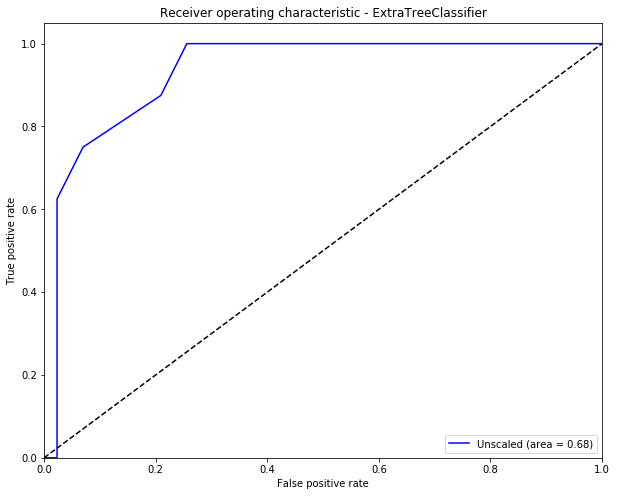

In [58]:
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label ="Unscaled (area = %0.2f)" % log_roc_auc, color ="blue")
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic - ExtraTreeClassifier')
plt.legend(loc="lower right")
plt.show()